In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd

# 행렬 연산
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family = "Malgun Gothic")
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import seaborn as sns

# 날짜 데이터 생성
from datetime import datetime

# 선형회귀분석 (절편(intercept) 추가)
import statsmodels.api as sm

# 자기상관 함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# 파일명, 변수, 값 등에 한글 포함시 engine = "python" 지정, parse_dates : 날짜 변수 식별
df_raw = pd.read_csv("data/환율.csv", engine = "python", parse_dates = ["APPL_DATE"])
df_raw

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294
...,...,...,...,...
268,JPY,2016-03-30,1026.90,0.8906
269,USD,2016-03-30,1153.00,1.0000
270,CNY,2016-03-31,176.96,0.1547
271,JPY,2016-03-31,1017.57,0.8895


## 변동 추세 확인 - 시간에 따른 환율 추세 그래프 생성

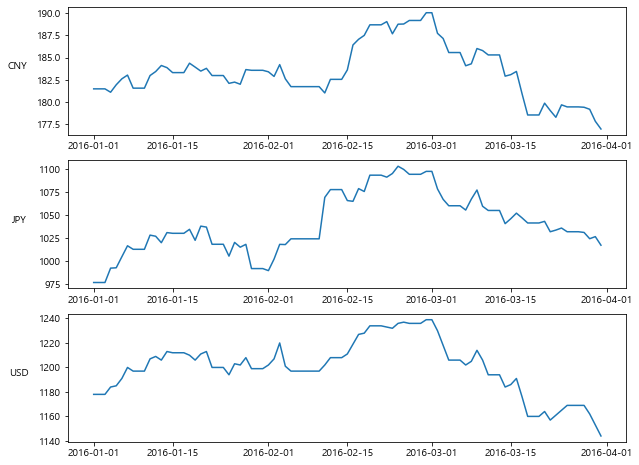

In [13]:
# 중국 위엔화와 엔화/달러 단위 크기가 다르기 때문에 각각 그래프를 생성 -> 3행 1열, 크기 : (10,8)
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

# zip 함수를 사용하면 zip 함수 안의 리스트들을 하나씩 출력
# 1번 loop : ax1, 311, "CNY"
# 2번 loop : ax2, 312, "JPY"
# 3번 loop : ax3, 313, "USD"
for (ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ["CNY", "JPY", "USD"]):
    # plot 추가, 311 -> 3행 1열의 1번 그래프
    ax.plot("APPL_DATE", "STD_RATE", data = df_raw[df_raw["CURRENCY"] == currency])
    # y축에 통화 표시 rotation : label 가로로 생성, labelpad : label과 그래프 사이의 거리
    ax.set_ylabel(currency, rotation = 0, labelpad = 20)

### ㄴ 초반 구간과 후반 구간의 평균이 다르고 변동이 달라 정상성이 만족되지 않음 -> 차분 필요 확인

## 시계열 분석
### : 데이터 분할 - 통화별 데이터 분할

In [19]:
# CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_CNY = df_raw[df_raw["CURRENCY"] == "CNY"].set_index("APPL_DATE")
df_CNY

,CURRENCY,STD_RATE,USD_CONV_DATE
APPL_DATE,,,
2016-01-01,CNY,181.48,0.1541
2016-01-02,CNY,181.48,0.1541
2016-01-03,CNY,181.48,0.1541
2016-01-04,CNY,181.10,0.1540
2016-01-05,CNY,181.94,0.1530
...,...,...,...
2016-03-27,CNY,179.45,0.1535
2016-03-28,CNY,179.41,0.1535
2016-03-29,CNY,179.18,0.1537


In [20]:
# drop method를 이용해 통화(CURRENCY)와 미달러 환산율(USD_CONV_DATE) 변수 제외
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)
df_CNY

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94
...,...
2016-03-27,179.45
2016-03-28,179.41
2016-03-29,179.18


In [21]:
# JPY 데이터 생성
df_JPY = df_raw[df_raw["CURRENCY"] == "JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

# USD 데이터 생성 : 실습용 데이터
df_USD = df_raw[df_raw["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

### : 데이터 분할 - train/test 데이터 분할

In [22]:
# Train & Test 데이터 분할 : 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [27]:
np.arange(len_idx)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [26]:
np.arange(len_idx) / len_idx

array([0.        , 0.01098901, 0.02197802, 0.03296703, 0.04395604,
       0.05494505, 0.06593407, 0.07692308, 0.08791209, 0.0989011 ,
       0.10989011, 0.12087912, 0.13186813, 0.14285714, 0.15384615,
       0.16483516, 0.17582418, 0.18681319, 0.1978022 , 0.20879121,
       0.21978022, 0.23076923, 0.24175824, 0.25274725, 0.26373626,
       0.27472527, 0.28571429, 0.2967033 , 0.30769231, 0.31868132,
       0.32967033, 0.34065934, 0.35164835, 0.36263736, 0.37362637,
       0.38461538, 0.3956044 , 0.40659341, 0.41758242, 0.42857143,
       0.43956044, 0.45054945, 0.46153846, 0.47252747, 0.48351648,
       0.49450549, 0.50549451, 0.51648352, 0.52747253, 0.53846154,
       0.54945055, 0.56043956, 0.57142857, 0.58241758, 0.59340659,
       0.6043956 , 0.61538462, 0.62637363, 0.63736264, 0.64835165,
       0.65934066, 0.67032967, 0.68131868, 0.69230769, 0.7032967 ,
       0.71428571, 0.72527473, 0.73626374, 0.74725275, 0.75824176,
       0.76923077, 0.78021978, 0.79120879, 0.8021978 , 0.81318

In [28]:
# mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_train

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94
...,...
2016-03-18,178.54
2016-03-19,178.54
2016-03-20,178.54


In [30]:
df_CNY_test = df_CNY[~mask]
df_CNY_test

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45
2016-03-28,179.41
2016-03-29,179.18
2016-03-30,177.83
2016-03-31,176.96


In [31]:
print("shape of train data: {}".format(df_CNY_train.shape))
print("shape of test data: {}".format(df_CNY_test.shape))

shape of train data: (82, 1)
shape of test data: (9, 1)


In [32]:
# 추가설명 : Train & Test 데이터 분할 : index 직접 지정
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


### : 데이터 분할 - 차분을 통해 정상성 데이터로 변환

<AxesSubplot:xlabel='APPL_DATE'>

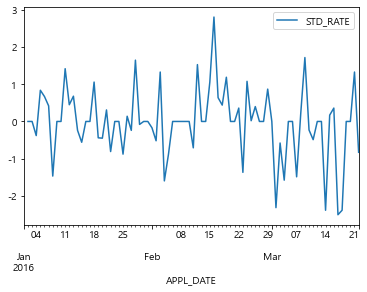

In [33]:
# 1차 차분 : z(t) - z(t-1)
# shift(n) : 앞의 n번째 행의 데이터를 가져옴

df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

### ㄴ 원 데이터보다는 시간의 흐름에 영향을 덜 받지만 정상성이 만족스럽지 않음

<AxesSubplot:xlabel='APPL_DATE'>

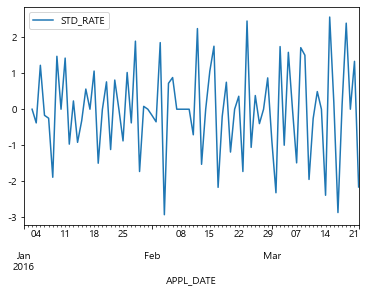

In [34]:
# 2차 차분 : (z(t) - z(t-1)) - (z(t-1) - z(t-2)) = z(t) - 2z(t-1) + z(t-2)

df_CNY_diff2 = df_CNY_train - 2 * (df_CNY_train.shift(1)) + df_CNY_train.shift(2)
df_CNY_diff2.plot()

### ㄴ (2차 차분으로) 시간에 따른 경향성을 가지지 않는 정상성을 만족

### - 자기상관 함수 및 부분 자기상관 함수
#### Lag를 30까지 해 ACF, PACF 산출

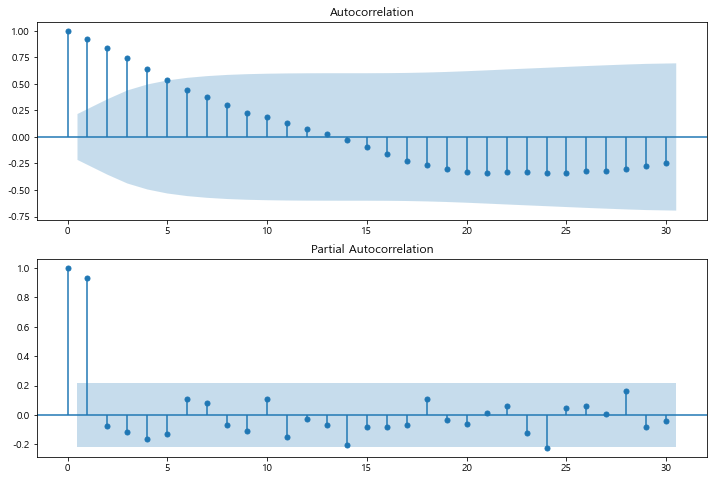

In [36]:
# 자기회귀 최대 p기간 지정
lag_size = 30
fig = plt.figure(figsize = (12,8))

# acf 그래프를 그릴 공간 생성
ax1 = fig.add_subplot(211)

# 자기상관 함수 그래프 plot_acf 함수 이용
fig = plot_acf(df_CNY_train["STD_RATE"], lags = lag_size, ax = ax1) # ["STD_RATE"] 생략 가능

# pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)

# 부분 자기상관 함수 그래프 plot_pacf 함수 사용
fig = plot_pacf(df_CNY_train["STD_RATE"], lags = lag_size, ax = ax2) # ["STD_RATE"] 생략 가능

### ㄴ ACF는 지속적으로 감소하고 p=13 시점에서 양에서 음으로 변함
###      PACF는 p=1 시점에서 0.9보다 크고 이후 급격히 감소(절단면)함. 
### 따라서 p=1, q=0 모델이 적당하다고 판단 -> ARMA(1,0)

## 시계열 모델

In [37]:
# Train 데이터 이용, AR(1), I(2, 차분), MA(0)인 ARIMA 모델
ts_model_cny = ARIMA(df_CNY_train, order = (1,2,0)) # p, d, q 가정

# 데이터 적합
# trend : 상수 포함 여부 "nc"이면 상수 미포함, full_output : 모든 출력 결과 표시
ts_result_cny = ts_model_cny.fit(trend = "c", full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Fri, 29 Oct 2021   AIC                            253.025
Time:                        14:51:17   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

C:\Users\user\anaconda3\envs\kongbig\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\user\anaconda3\envs\kongbig\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so 

## 예측 결과 및 해석

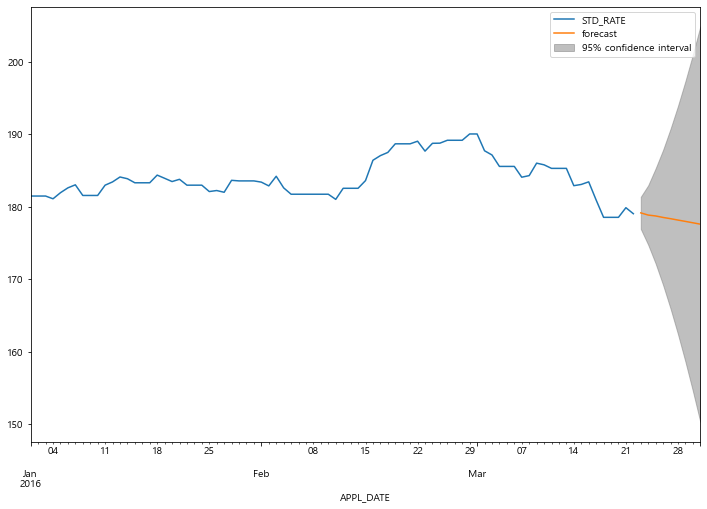

In [40]:
# 예측 시작/종료 날짜 지정
start_time = df_CNY_test.index.min() # 2016-03-23
end_time = df_CNY_test.index.max() # 2016-03-31
fig, ax = plt.subplots(figsize = (12,8))

# 예측 전까지 데이터
ax = df_CNY_train.plot(ax = ax)

# 예측 그래프 생성 함수, start : 예측 시작, end : 예측 종료, plot_insample : 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
fig = ts_result_cny.plot_predict(start = start_time, end = end_time, ax = ax, plot_insample = False)

### ㄴ2016년 3월 31일까지의 예측값 -> 지속적으로 감소할 것으로 예측
### ㄴ 예측값에 대한 95% 신뢰구간 (상, 하 회색 영역)

In [44]:
# 전체 기간의 실제값, 예측갑 확인
start_time = pd.to_datetime("2016-01-03") # 차분=2 -> 시작일자 +2 이후부터 예측값 생성됨

y_pred = ts_result_cny.predict(start = start_time, end = end_time, typ = "levels")

df_merge = df_CNY # 실제값 저장
df_merge["예측값"] = y_pred # 예측값 저장 및 변수명 지정
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667


<AxesSubplot:xlabel='APPL_DATE'>

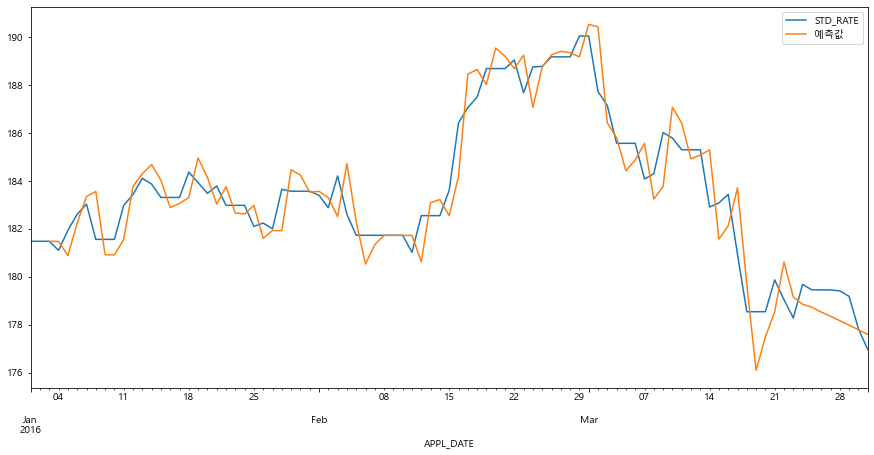

In [45]:
# 추세 그래프 생성 및 확인
df_merge.plot(y = ["STD_RATE", "예측값"], figsize = (15, 7))

### ㄴ 모델 훈련구간은 실제값 대비 지연(lag)현상이 확인되며 예측 구간은 오차가 큼